---

# Visualize and analyze tracking output 

## Imports

In [2]:
import numpy as np 
import xarray as xr 
import pandas as pd 
import matplotlib.pyplot as plt
import tobac 
print('For this cookbook, we are using tobac version:', tobac.__version__)

For this cookbook, we are using tobac version: 1.6.0


### Read in data from previous steps again

In [11]:
mask_file_name = 'MPAS_tobac_storm_mask_iwp.nc'
mpas_regridded_file_name = 'MPAS_regridded_2020_07_01.nc'

# get the mask 
mask = xr.open_dataset(mask_file_name).segmentation_mask

# the dataset that contains the three regridded variables 
mpas_regridded = xr.open_dataset(mpas_regridded_file_name)

## Storm mask
Plot the mask file of detected features for one timestep on top of the MPAS ice water path field. 


In [123]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

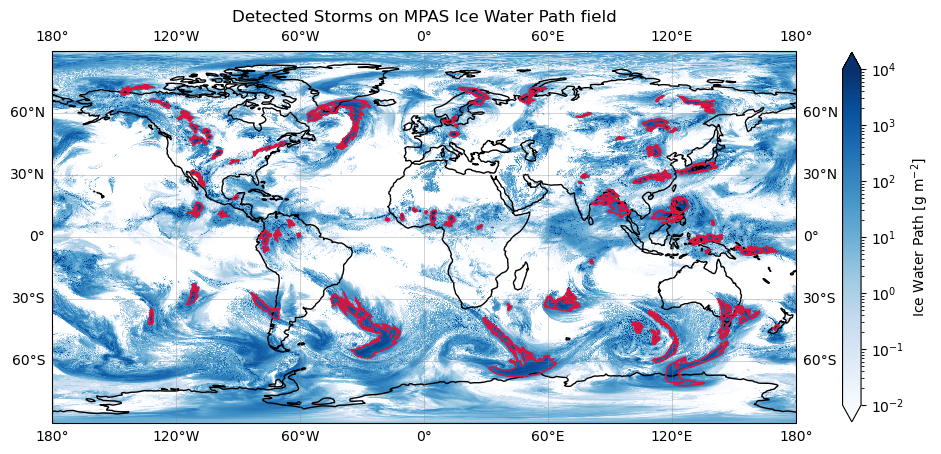

In [124]:
# Plot first timestep of ice water path
tt = 0 
mask_t = mask.isel(time = tt)
storm_ids = np.unique(mask_t.values[~np.isnan(mask_t.values)])
storm_ids = storm_ids[storm_ids > 0] 
iwp_t = mpas_regridded['ice_water_path'].isel(time = tt) 
lat = mask['lat'].values
lon = mask['lon'].values

fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # PlateCarree expects lat/lon coords
lw = 1.0 # linewidth for coastlines, contours and tracks 

# Plot the DataArray using xarray's plot function, but give it the axis
iwp_t.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),  
    cmap='Blues',
    norm=LogNorm(vmin=1e-2, vmax=1e4),
    cbar_kwargs={'label': 'Ice Water Path [g m$^{-2}$]', 'shrink': 0.8}
)

# Add coastlines
ax.coastlines(resolution='110m', linewidth=lw)

# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)


# Create a contour plot for mask regions
CS = ax.contour(
        lon, lat, mask_t.where(mask_t == 0 , 1),
        levels=[0.5],
        colors=['crimson'],
        linewidths=[lw],
        transform=ccrs.PlateCarree())

plt.title('Detected Storms on MPAS Ice Water Path field')
plt.show()

## Simple analysis with output data: What is the relationship between cloud ice water path, liquid water path, and surface precipitation? 

### Computation of storm statistics 

One big advantage of global model data are the physically consistent fields. We can use **tobac** to calculate additional bulk statistics for the detected storm objects using other fields of the model data. 

In this example, we explore what the surface precipitation (*rainnc*) and liquid water path (*liquid_water_path*) are for the ice water path-based detected clouds. These two fields will tell us more about whether and how much it is raining underneath a cloud that produces lots of cloud ice and how the total amount of liquid condensate is related to the total amount of frozen condensate.

In [13]:
# get all tracked storm objects 
track_file_name = 'MPAS_tobac_storm_tracks_iwp.nc'
# convert back to a pandas dataframe 
tracks = xr.open_dataset(track_file_name).to_dataframe()
tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp,cell,time_cell
index,,,,,,,,,,,,,,,,,
0,0,1438,962.170213,1843.797872,94,2.5,52,2020-07-01 00:00:00,2020-07-01 00:00:00,6.217021,4.379787,174,19.396437,717.833252,4.125478,52,0 days 00:00:00
1,0,1809,1045.127083,707.841667,480,2.5,64,2020-07-01 00:00:00,2020-07-01 00:00:00,14.512708,-109.215833,1943,23.331123,4343.843262,2.235637,64,0 days 00:00:00
2,0,2119,1162.725490,2557.274510,51,2.5,75,2020-07-01 00:00:00,2020-07-01 00:00:00,26.272549,75.727451,96,25.836090,442.057312,4.604764,75,0 days 00:00:00
3,0,2935,1602.132353,356.352941,68,2.5,124,2020-07-01 00:00:00,2020-07-01 00:00:00,70.213235,-144.364706,757,8.381392,948.486938,1.252955,124,0 days 00:00:00
4,1,1470,961.965517,1843.396552,116,2.5,178,2020-07-01 00:30:00,2020-07-01 00:30:00,6.196552,4.339655,200,20.081499,848.819946,4.244100,52,0 days 00:30:00


In [14]:
# calculate statistics based on additional variables in regridded dataset
tracks= tobac.utils.bulk_statistics.get_statistics_from_mask(
    tracks, mask, mpas_regridded.liquid_water_path / 1000, statistic={"max_lwp": np.nanmax, "mean_lwp": np.nanmean, "total_lwp": np.nansum}, default=np.nan) 

tracks = tobac.utils.bulk_statistics.get_statistics_from_mask(
    tracks, mask, mpas_regridded.rainnc , statistic={"max_precip": np.nanmax, "mean_precip": np.nanmean, "total_precip": np.nansum}, default=np.nan) 

# save features (optional, but practically if that takes some time)
tracks.to_xarray().to_netcdf('MPAS_feature_statistics.nc')

In [15]:
# the bulk statistics are simply added to the dataframe:
print(tracks.columns)

Index(['frame', 'idx', 'hdim_1', 'hdim_2', 'num', 'threshold_value', 'feature',
       'time', 'timestr', 'lat', 'lon', 'ncells', 'max_iwp', 'total_iwp',
       'mean_iwp', 'cell', 'time_cell', 'max_lwp', 'mean_lwp', 'total_lwp',
       'max_precip', 'mean_precip', 'total_precip'],
      dtype='object')


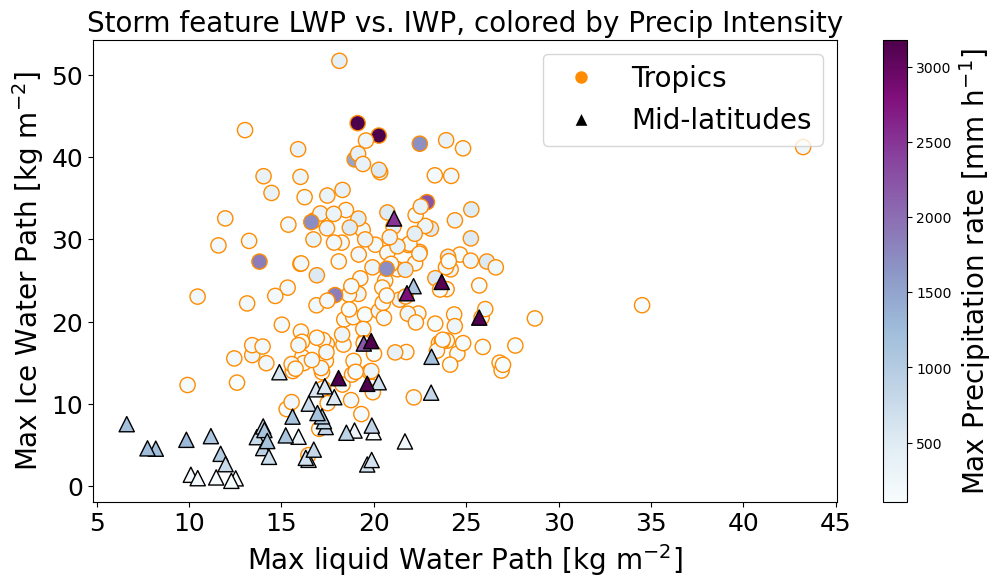

In [16]:
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D

# variables 
lwp = tracks["max_lwp"].values
iwp = tracks["max_iwp"].values
precip = tracks["max_precip"].values
lat  = tracks.lat.values 
lon = tracks.lon.values 

# subset by climate regime 
tropics_mask = (lat >= -30) & (lat <= 30)
midlat_mask = ((lat >= 30) & (lat <= 60)) | ((lat <= -30) & (lat >= -60))

lwp_trop = lwp[tropics_mask]
iwp_trop = iwp[tropics_mask]
precip_trop = precip[tropics_mask]

lwp_mid = lwp[midlat_mask]
iwp_mid = iwp[midlat_mask]
precip_mid = precip[midlat_mask]

# Plot settings
size = 120
fs = 20
cmap = 'BuPu'

plt.figure(figsize=(12, 6))

sc1 = plt.scatter(iwp_trop, lwp_trop, c = precip_trop, cmap = cmap , s=size, marker='o', edgecolors='darkorange',  label='Tropics') #norm=LogNorm())
sc2 = plt.scatter(iwp_mid, lwp_mid, c = precip_mid, cmap = cmap, s=size,  marker='^', edgecolors='k',  label='Mid-latitudes') #, norm=LogNorm())
cbar = plt.colorbar(sc1)
cbar.set_label("Max Precipitation rate [mm h$^{-1}$]", size = fs)


legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Tropics',
           markerfacecolor='darkorange', markersize=10),
    Line2D([0], [0], marker='^', color='w', label='Mid-latitudes',
           markerfacecolor='k', markersize=10)
]
plt.legend(handles=legend_elements, fontsize=fs)


plt.xlabel("Max liquid Water Path [kg m$^{-2}$]", fontsize = fs )
plt.ylabel("Max Ice Water Path [kg m$^{-2}$]",  fontsize = fs)
plt.title("Storm feature LWP vs. IWP, colored by Precip Intensity", fontsize= fs)
plt.tick_params(axis='both', which='major', labelsize=fs - 2)

plt.show()

---